In [1]:
import sys
import os
if os.path.abspath('../sample') not in sys.path:
    sys.path.insert(0, os.path.abspath('../sample'))
if os.path.abspath('../model') not in sys.path:
    sys.path.insert(0, os.path.abspath('../model'))
    
from current_plot import *
import data_manipulation as dm
import autosimilarity_segmentation as as_seg
import tensor_factory as tf
import pandas as pd
import features
import numpy as np
import soundfile as sf
import NTD
import hide_code as hide
import overall_scripts as scr

This study is divided in 3 Notebooks, all starting with a 5.

These 3 notebooks aim at studying 3 different kernels for the convolution measure.

They should be read in their logical order.

Note, as a prerequisite, that the diagonal of all our kernels is zero. Indeed, we consider that the diagonal of autosimilarity matrices doesn't hold structural information, and that considering it is counter-productive.

More details about the design of these kernels can be found in the Notebook "Appendix - Focus on the segmentation algorithm".

# Mixed kernel

This kernel is a trade-off between local and "longer" term similarities.

Concretely, it is a sum of both previous kernels. It is composed of 0 in its diagonal, 2 in the 8 bands surrounding the diagonal, and 1 elsewhere.

It looks like: <img src="imgs/mixed_kernel.png" width="150"/>

(or, in a matrix form: $\left[ \begin{matrix} 0 & 2 & 2 & 2& 2 & 1 & 1 & 1\\  2 & 0 & 2 & 2 & 2& 2 & 1 & 1\\  2&2 & 0 & 2 & 2 & 2& 2 & 1\\ 2&2&2 & 0 & 2 & 2 & 2& 2\\ 2 & 2 & 2& 2 & 0 & 2&2&2\\ 1 & 2 & 2 & 2& 2 & 0 & 2&2\\ 1 & 1 & 2 & 2 & 2& 2 & 0 & 2\\ 1 & 1 & 1& 2 & 2 & 2& 2 & 0\\ \end{matrix} \right]$ (of size 8 here)).

Mathematically, for a segment ($b_1, b_2$), the associated cost will be $c_{b_1,b_2} = \frac{1}{b_2 - b_1 + 1}(\sum_{i,j = 0, i \ne j}^{n - 1}  a_{i + b_1, j + b_1} + \sum_{i,j = 0, 1 \leq |i - j| \leq 4}^{n - 1}  a_{i + b_1, j + b_1})$.

It's called mixed kernel as it mixes both previous paradigms.

## Fixed ranks

Below are segmentation results with different ranks values, but each time fixed over the entire RWC Pop dataset.

Results are computed with tolerance of respectively 0.5 seconds and 3 seconds. 

In [3]:
annotations_type = "MIREX10"
ranks_rhythm = [12,16,20,24,28,32,36,40,44,48]
ranks_pattern = [12,16,20,24,28,32,36,40,44,48]
zero_five_chr, three_chr = hide.compute_ranks_RWC(ranks_rhythm,ranks_pattern, W = "chromas", annotations_type = annotations_type,
                                                  subdivision=96, penalty_weight = 1,penalty_func = "modulo8")

C:\Users\amarmore\Desktop\Projects\PhD main projects\On Git\Code\Tensor factorization\sample\autosimilarity_segmentation.py:44: RuntimeWarning: invalid value encountered in true_divide
  this_array = np.array([list(i/np.linalg.norm(i)) for i in this_array.T]).T


## Oracle ranks

In this condition, we only keep the ranks leading to the highest F measure.

In that sense, it's an optimistic upper bound on metrics.

In [4]:
hide.printmd("**A 0.5 secondes:**")
best_chr_zero_five = hide.best_f_one_score_rank(zero_five_chr)
hide.printmd("**A 3 secondes:**")
best_chr_three = hide.best_f_one_score_rank(three_chr)

**A 0.5 secondes:**

,Vrai Positifs,Faux Positifs,Faux Négatifs,Precision,Rappel,F mesure
En optimisant la F mesure sur chaque chanson:,13.77,5.85,5.04,0.7164,0.7383,0.7199


**A 3 secondes:**

,Vrai Positifs,Faux Positifs,Faux Négatifs,Precision,Rappel,F mesure
En optimisant la F mesure sur chaque chanson:,16.09,3.44,2.72,0.8352,0.8594,0.8406


Below is presented the distribution of the optimal ranks in the "oracle ranks" condition, _i.e._ the distribution of the ranks for $H$ and $Q$ which result in the highest F measure for the different songs.

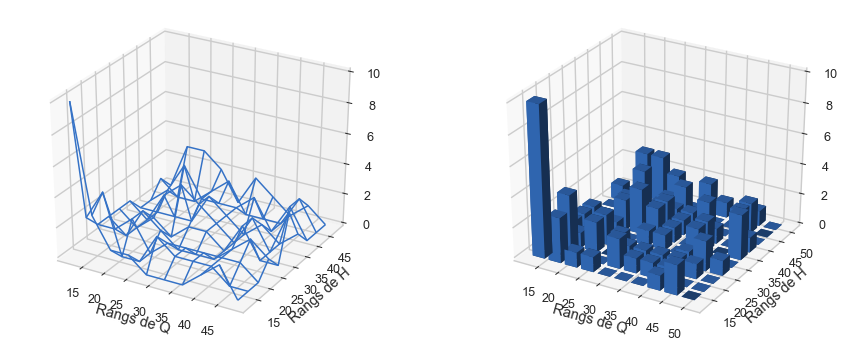

In [5]:
hide.plot_3d_ranks_study(zero_five_chr, ranks_rhythm, ranks_pattern)

Below is shown the distribution histogram of the F measure obtained with the oracle ranks.

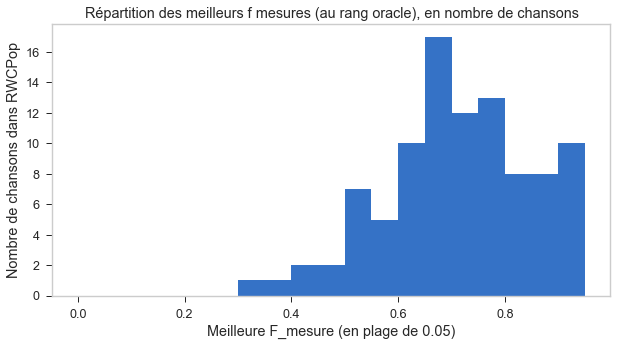

In [6]:
hide.plot_f_mes_histogram(zero_five_chr)

## Results when, in addition of the ranks, we also fit the $\lambda$ parameter

In addition of the previous results, we also tried to fit the $\lambda$ parameter for each rank couple (see previous Notebook, 4th one). They are shown below.

In [8]:
ranks_rhythm = [12,16,20,24,28,32,36,40,44,48]
ranks_pattern = [12,16,20,24,28,32,36,40,44,48]
range_param = [i/10 for i in range(0,20)]
zero_five, three = hide.compute_ranks_with_param_RWC(ranks_rhythm, ranks_pattern, range_param, annotations_type = "MIREX10", subdivision = 96, penalty_func = "modulo8")